In [1]:
%load_ext autoreload
%autoreload 2

In [156]:
%matplotlib inline

from matplotlib import image as mpimage
from matplotlib import pyplot as plt

import yaml
import os
import shutil
from datetime import datetime

import pandas as pd
import numpy as np
import math
import random

from sklearn.model_selection import train_test_split

from keras.callbacks import TensorBoard
from keras.preprocessing.image import ImageDataGenerator

In [3]:
from model.cae import CAE

from utils import plot_paired_imgs
from utils import plot_sample_imgs

Using TensorFlow backend.


In [4]:
SEED = 1993

In [5]:
with open('conf/user_conf.yaml', 'r') as f:
    conf = yaml.load(f)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


In [83]:
patches_path = os.path.join(conf['data_path'], 'slides', 'patches')

In [18]:
training_path = os.path.join(conf['data_path'], 'slides', 'train')
test_path = os.path.join(conf['data_path'], 'slides', 'test')

if os.path.exists(training_path):
    shutil.rmtree(training_path)
os.mkdir(training_path)

if os.path.exists(test_path):
    shutil.rmtree(test_path)
os.mkdir(test_path)

In [19]:
slides_df = pd.read_csv(os.path.join(conf['data_path'], 'slides_metadata.csv'), sep='|')

In [100]:
slide_to_patch_columns = ['case_id', 'sample_id', 'slide_id', 'disease_type', 'sample_type', 
                          'percent_normal_cells', 'percent_stromal_cells', 'percent_tumor_cells', 'percent_tumor_nuclei']

In [107]:
regex_slide_id = re.compile('.*(TCGA.*)_\d{2}_\d{2}\.png')

## Train/Test split in Slides

The idea is to avoid using patches from the same slide both in train and test.

In [20]:
slides_df = slides_df[slides_df['sample_type'].isin(['Primary Tumor', 'Solid Tissue Normal'])]

In [21]:
slides_df['sample_type'].value_counts(normalize=True)

Primary Tumor          0.907527
Solid Tissue Normal    0.092473
Name: sample_type, dtype: float64

In [22]:
slides_train, slides_test = train_test_split(slides_df, test_size=0.2, 
                                             stratify=slides_df['sample_type'], random_state=SEED) 

In [23]:
slides_train['sample_type'].value_counts(normalize=True)

Primary Tumor          0.908602
Solid Tissue Normal    0.091398
Name: sample_type, dtype: float64

In [24]:
slides_train['sample_type'].value_counts(normalize=True)

Primary Tumor          0.908602
Solid Tissue Normal    0.091398
Name: sample_type, dtype: float64

## Read Images

__Prepare DataFrame__

In [116]:
patches_df = []

for file_name in os.listdir(patches_path):
    
    if not file_name.endswith('.png'):
        continue
    
    slide_id = regex_slide_id.match(file_name).groups()[0]
    patches_df.append({'slide_id': slide_id, 'filename': file_name})
    
patches_df = pd.DataFrame(patches_df)

In [117]:
patches_df.head(5)

,filename,slide_id
0,TCGA-IB-8127-01A-01-BS1_11_06.png,TCGA-IB-8127-01A-01-BS1
1,TCGA-IB-AAUR-01A-02-TSB_06_11.png,TCGA-IB-AAUR-01A-02-TSB
2,TCGA-F2-7273-01A-01-TS1_02_03.png,TCGA-F2-7273-01A-01-TS1
3,TCGA-IB-7649-01A-01-BS1_12_11.png,TCGA-IB-7649-01A-01-BS1
4,TCGA-IB-A6UF-01A-02-TSB_16_12.png,TCGA-IB-A6UF-01A-02-TSB


In [178]:
training_patches_df = patches_df.merge(slides_train[slide_to_patch_columns], on='slide_id')
test_patches_df = patches_df.merge(slides_test[slide_to_patch_columns], on='slide_id')

In [179]:
training_patches_df.head(5)

,filename,slide_id,case_id,sample_id,disease_type,sample_type,percent_normal_cells,percent_stromal_cells,percent_tumor_cells,percent_tumor_nuclei
0,TCGA-IB-8127-01A-01-BS1_11_06.png,TCGA-IB-8127-01A-01-BS1,TCGA-IB-8127,TCGA-IB-8127-01A,Ductal and Lobular Neoplasms,Primary Tumor,30.0,15.0,55.0,60.0
1,TCGA-IB-8127-01A-01-BS1_06_03.png,TCGA-IB-8127-01A-01-BS1,TCGA-IB-8127,TCGA-IB-8127-01A,Ductal and Lobular Neoplasms,Primary Tumor,30.0,15.0,55.0,60.0
2,TCGA-IB-8127-01A-01-BS1_07_10.png,TCGA-IB-8127-01A-01-BS1,TCGA-IB-8127,TCGA-IB-8127-01A,Ductal and Lobular Neoplasms,Primary Tumor,30.0,15.0,55.0,60.0
3,TCGA-IB-8127-01A-01-BS1_07_09.png,TCGA-IB-8127-01A-01-BS1,TCGA-IB-8127,TCGA-IB-8127-01A,Ductal and Lobular Neoplasms,Primary Tumor,30.0,15.0,55.0,60.0
4,TCGA-IB-8127-01A-01-BS1_17_09.png,TCGA-IB-8127-01A-01-BS1,TCGA-IB-8127,TCGA-IB-8127-01A,Ductal and Lobular Neoplasms,Primary Tumor,30.0,15.0,55.0,60.0


In [114]:
images_train_sample = np.array([mpimage.imread(os.path.join(patches_path, x)) for x in training_patches_df['patch_file'].iloc[:100]])

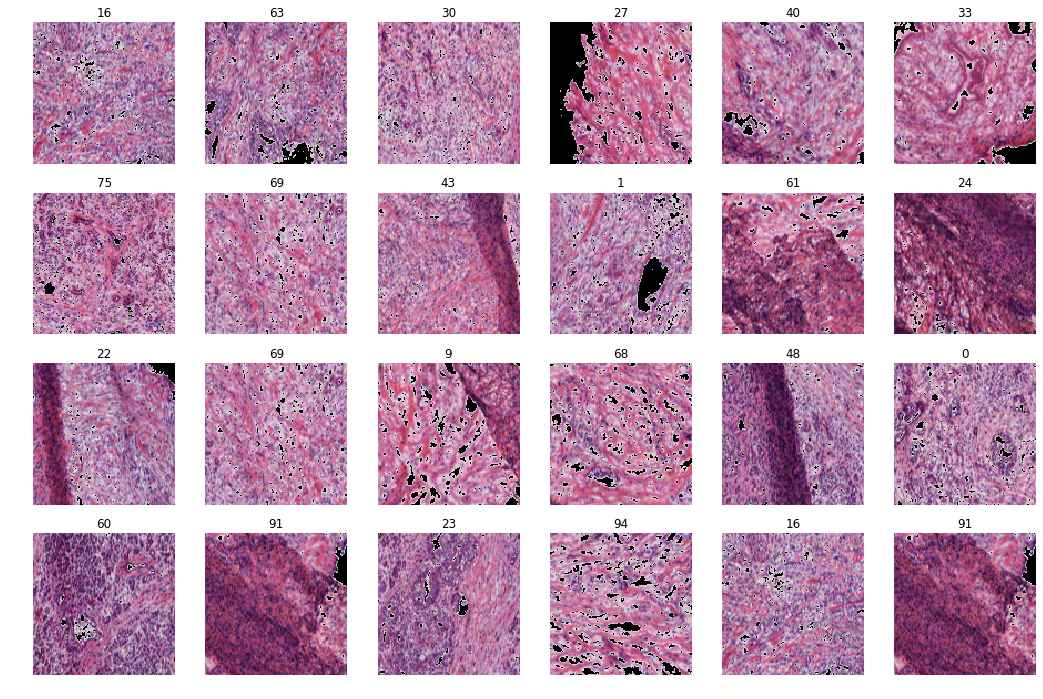

In [115]:
plot_sample_imgs(images_train_sample, n_rows=4, n_cols=6)

In [203]:
BATCH_SIZE = 32
EPOCHS = 320
IMAGE_SIZE = 128

In [204]:
train_datagen = ImageDataGenerator(validation_split=0.2)

train_generator = train_datagen.flow_from_dataframe(training_patches_df, directory=patches_path, x_col='filename', 
                                                    target_size=(IMAGE_SIZE, IMAGE_SIZE), color_mode='rgb', class_mode='input', 
                                                    batch_size=BATCH_SIZE, subset='training', seed=SEED)

validation_generator = train_datagen.flow_from_dataframe(training_patches_df, directory=patches_path, x_col='filename', 
                                                         target_size=(IMAGE_SIZE, IMAGE_SIZE), color_mode='rgb', class_mode='input', 
                                                         batch_size=BATCH_SIZE, subset='validation', seed=SEED)

Found 14923 images.
Found 3730 images.


In [207]:
test_patches_df = test_patches_df.iloc[:50]

In [208]:
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(test_patches_df, directory=patches_path, x_col='filename', 
                                                  target_size=(IMAGE_SIZE, IMAGE_SIZE), color_mode='rgb', class_mode='input', 
                                                  batch_size=1, seed=SEED)

Found 50 images.


__Create Model__

In [209]:
# initialize ConvAutoEncoder model
cae = CAE(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), output_dim=20, filters=[8, 16, 32],
          path='/home/jupyter/data/model')

In [210]:
tb = TensorBoard(log_dir='./logs/' + datetime.now().strftime('%Y%m%d_%H%M'), 
                 write_grads=True, write_images=True, histogram_freq=0)

In [ ]:
cae.model.fit_generator(generator = train_generator, 
                        validation_data = validation_generator,
                        steps_per_epoch = math.ceil(train_generator.samples / BATCH_SIZE),
                        validation_steps = math.ceil(validation_generator.samples / BATCH_SIZE),
                        epochs = EPOCHS, 
                        callbacks = [tb])

Epoch 1/320
467/467 [==============================] - 31s 67ms/step - loss: 21898.7306 - val_loss: 23748.9622
Epoch 2/320
467/467 [==============================] - 30s 64ms/step - loss: 21902.8771 - val_loss: 23748.9623
Epoch 3/320
467/467 [==============================] - 31s 66ms/step - loss: 21900.3009 - val_loss: 23748.9622
Epoch 4/320
467/467 [==============================] - 30s 64ms/step - loss: 21902.7540 - val_loss: 23748.9624
Epoch 5/320
467/467 [==============================] - 31s 66ms/step - loss: 21899.3112 - val_loss: 23748.9623
Epoch 6/320
467/467 [==============================] - 30s 65ms/step - loss: 21903.9807 - val_loss: 23748.9623
Epoch 7/320
467/467 [==============================] - 30s 65ms/step - loss: 21900.4092 - val_loss: 23748.9622
Epoch 8/320
115/467 [======>.......................] - ETA: 18s - loss: 21867.2571

In [ ]:
cae.save_weights()

In [199]:
test_output = cae.model.predict_generator(test_generator, steps=50)

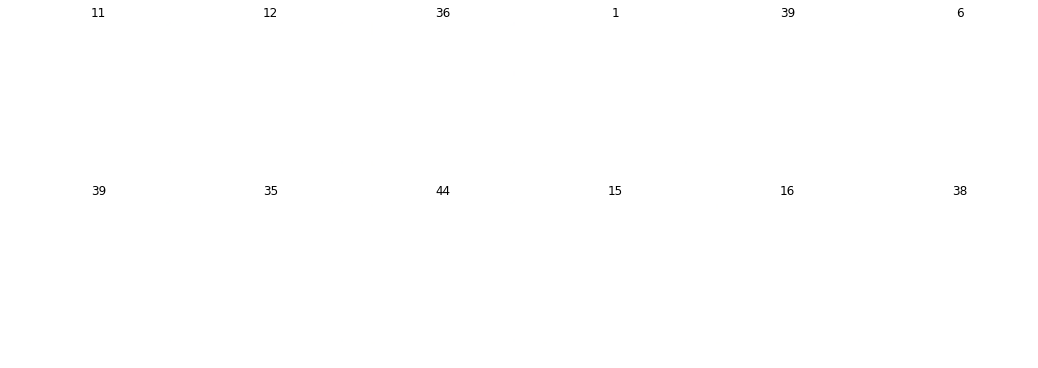

In [200]:
plot_sample_imgs(test_output)